# 基于MindSpore框架的手写数字识别

## 构建LeNet5模型
按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。
![LeNet5的网络结构图](assets/lenet.png)

In [1]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal

In [2]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """weight initial for conv layer"""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


def fc_with_initialize(input_channels, out_channels):
    """weight initial for fc layer"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    """weight initial"""
    return TruncatedNormal(0.02)

In [3]:
class LeNet5(nn.Cell):
    """
    Lenet network

    Args:
        num_class (int): Num classes. Default: 10.

    Returns:
        Tensor, output tensor
    Examples:
        >>> LeNet(num_class=10)

    """
    def __init__(self, num_class=10, channel=1):
        super(LeNet5, self).__init__()
        self.num_class = num_class
        self.conv1 = conv(channel, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# 设置全局种子
全局种子可用于numpy.random, mindspore.common.Initializer以及mindspore.nn.probability.distribution。


In [5]:
from mindspore import set_seed
seed = 1024
set_seed(seed)

## 下载并处理数据集
MNIST数据集是由10类28∗28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。
利用MindSpore Vision提供的的Mnist模块，将数据集下载、解压到指定位置并进行数据处理。

In [4]:
from mindvision.dataset import Mnist
from mindspore.dataset.vision import Resize, HWC2CHW

trans = [Resize([32, 32]),
            HWC2CHW(),]

# 下载并处理MNIST数据集
download_train = Mnist(path="./mnist", split="train", batch_size=128, repeat_num=1, shuffle=True, transform=trans, download=True)
download_eval = Mnist(path="./mnist", split="test", batch_size=128, transform=trans, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()


## 创建模型

In [6]:
network = LeNet5(num_class=10, channel=1)
print(network)

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x00000138F7A48E80>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x00000138F7A488B0>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


## 定义损失函数和优化器
损失函数这里使用交叉熵损失函数SoftmaxCrossEntropyWithLogits, 优化器这里使用Momentum。

In [7]:
import mindspore.nn as nn
# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.001, momentum=0.9)

## 训练及保存模型
在开始训练之前，MindSpore需要提前声明网络模型在训练过程中是否需要保存中间过程和结果，因此使用ModelCheckpoint接口用于保存网络模型和参数，以便进行后续的Fine-tuning（微调）操作。

In [8]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数，模型训练保存参数的step为1875
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="lenet", directory="./lenet_mindspore", config=config_ck)

通过MindSpore提供的model.train接口可以方便地进行网络的训练，LossMonitor可以监控训练过程中loss值的变化。

In [9]:
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型，并保存为lenet-1_1875.ckpt文件
model.train(40, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875)])

Epoch time: 8610.672 ms, per step time: 18.399 ms, avg loss: 0.677
Epoch time: 8240.770 ms, per step time: 17.608 ms, avg loss: 0.106
Epoch time: 8451.041 ms, per step time: 18.058 ms, avg loss: 0.078
Epoch time: 8658.026 ms, per step time: 18.500 ms, avg loss: 0.063
Epoch:[  4/ 40], step:[    3/  468], loss:[0.038/0.035], time:22.752 ms, lr:0.01000
Epoch time: 8463.565 ms, per step time: 18.085 ms, avg loss: 0.052
Epoch time: 8338.240 ms, per step time: 17.817 ms, avg loss: 0.046
Epoch time: 8370.767 ms, per step time: 17.886 ms, avg loss: 0.040
Epoch time: 8368.011 ms, per step time: 17.880 ms, avg loss: 0.034
Epoch:[  8/ 40], step:[    6/  468], loss:[0.036/0.033], time:22.672 ms, lr:0.01000
Epoch time: 8571.460 ms, per step time: 18.315 ms, avg loss: 0.031
Epoch time: 8334.793 ms, per step time: 17.809 ms, avg loss: 0.028
Epoch time: 8330.647 ms, per step time: 17.801 ms, avg loss: 0.026
Epoch time: 8322.648 ms, per step time: 17.783 ms, avg loss: 0.024
Epoch:[ 12/ 40], step:[    9

通过模型运行测试数据集得到的结果，验证模型的泛化能力：
使用model.eval接口读入测试数据集。
使用保存后的模型参数进行推理。

In [10]:
acc = model.eval(dataset_eval)
print("{}".format(acc))

{'accuracy': 0.9910857371794872}


## 实例验证
生成的模型进行单个图片数据的分类预测。

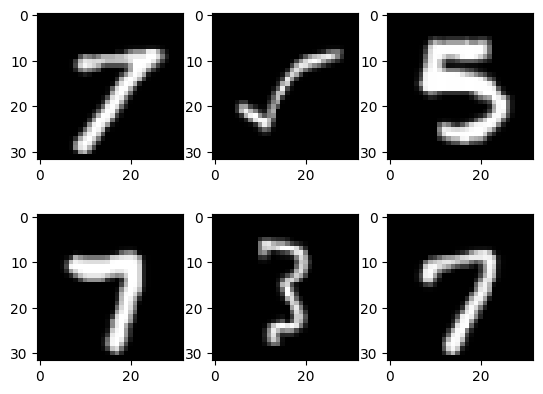

Predicted: "[7 5 5 7 3 7]", Actual: "[7 5 5 7 3 7]"


In [12]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt
from mindspore.dataset.vision import Resize, HWC2CHW

trans = [Resize([32, 32]),
            HWC2CHW(),]
mnist = Mnist("./mnist", split="train", batch_size=6, transform=trans)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')

从上面的打印结果可以看出，预测值与目标值完全一致。